In [21]:
import sys
import time
import calendar
import datetime

from geopy.geocoders import Nominatim
from scipy.stats import poisson

from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql.functions import lower, col, size, length, split
from operator import add
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


spark = SparkSession\
  .builder \
  .appName("Twitter_app") \
  .getOrCreate()

### Loading Stop Words:

In [2]:
## Reading from the stopword file:
text_file = open("datasets/stop_words_english.txt", "r")
lines = text_file.read()

## Creating the stop word array:
stopWords = lines.split()
# Adding http and https to it:
stopWords.append('http')
stopWords.append('https')
stopWords[-10:]

['whim',
 'whod',
 'whos',
 'widely',
 'words',
 'world',
 'youd',
 'youre',
 'http',
 'https']

### Loading the Data:

In [3]:
#Load the data
data = spark.read.format('json').options(header='true', inferSchema='true') \
  .load('./datasets/NoFilterEnglish2020-02-04.json')

### Question 1

##### Words preprocessed:

In [4]:
# Clean text
clean_texts = data.select('*', lower(f.regexp_replace(f.col('text'), r'[^a-zA-Z#@,!\\s]', ' ')).alias('text2'))\
                  .drop('text')\
                  .withColumnRenamed('text2', 'text')

clean_texts.select('text').show(1, False)

+---------------------------------------------------------+
|text                                                     |
+---------------------------------------------------------+
|@theythemsbian thank you for being brave enough to say it|
+---------------------------------------------------------+
only showing top 1 row



#### Tokenize the words:

In [5]:
# Tokenize text
tokenizer = Tokenizer(inputCol='text', outputCol='words_t')
clean_word_tokens = tokenizer.transform(clean_texts)

clean_word_tokens.select('words_t').show(1, False)

+--------------------------------------------------------------------+
|words_t                                                             |
+--------------------------------------------------------------------+
|[@theythemsbian, thank, you, for, being, brave, enough, to, say, it]|
+--------------------------------------------------------------------+
only showing top 1 row



#### Remove useless words:

By useless, we mean the words of size 2 or less.

In [6]:
## Defining the function: (udf: user defined function)
filter_length_udf = f.udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
clean_word_tokens = clean_word_tokens.withColumn('words', filter_length_udf(col('words_t')))

clean_word_tokens.select('words').show(1, False)

+------------------------------------------------------------+
|words                                                       |
+------------------------------------------------------------+
|[@theythemsbian, thank, you, for, being, brave, enough, say]|
+------------------------------------------------------------+
only showing top 1 row



#### Creating the view words:

In [7]:
exp_words = clean_word_tokens.withColumn('word', f.explode('words'))\
                             .drop('words')
                 
#Tokenizer
exp_words.select('text', 'word').show(4)

exp_words.createOrReplaceTempView("words")



+--------------------+--------------+
|                text|          word|
+--------------------+--------------+
|@theythemsbian th...|@theythemsbian|
|@theythemsbian th...|         thank|
|@theythemsbian th...|           you|
|@theythemsbian th...|           for|
+--------------------+--------------+
only showing top 4 rows



#### Getting most frequent words in a given period of time using SPARK SQL:

In [8]:
def FreqWords(ts1, ts2, table = "words"):

    sqlDF = spark.sql("SELECT word, count(*) AS word_count " + 
                      "FROM {} ".format(table) + 
                      "WHERE {0}.timestamp_ms BETWEEN {1} AND {2} ".format(table, ts1, ts2)+ 
                      "GROUP BY word " + 
                      "ORDER BY word_count DESC")
    sqlDF.show(10)
    return sqlDF

In [9]:
ts1 = 1580770795658
ts2 = 1580770796665


t1 = time.time()
FreqWords(ts1, ts2, table = "words")
t2 = time.time()

print("time spent computing: {:.4g}".format(t2-t1))

+-----+----------+
| word|word_count|
+-----+----------+
|  the|        13|
|https|         7|
| this|         6|
|  you|         6|
|  for|         4|
|  can|         4|
| need|         3|
| make|         3|
|  him|         2|
|  not|         2|
+-----+----------+
only showing top 10 rows

time spent computing: 6.276


#### Getting most frequent words in a given period of time using SPARK only:

In [10]:
ts1 = 1580770795658
ts2 = 1580770796665

## Timing the operation:
t1 = time.time()

exp_words.filter(f.col('timestamp_ms').between(ts1, ts2) )\
         .groupBy('word') \
         .count() \
         .sort('count', ascending=False) \
         .show(10)

t2 = time.time()


print("time spent computing: {:.4g}".format(t2-t1))

+-----+-----+
| word|count|
+-----+-----+
|  the|   13|
|https|    7|
|  you|    6|
| this|    6|
|  can|    4|
|  for|    4|
| need|    3|
| make|    3|
|  who|    2|
| rare|    2|
+-----+-----+
only showing top 10 rows

time spent computing: 5.22


##### Conclusion:

We can see that both methods are equivalent in computing time and yield to the same results. Choosing between both is just a question of taste. We Personally prefer **SQL** querying.

### Question 2

#### Removing stop words:

In [11]:
# Removing the stopwords from the array of strings
sc = spark.sparkContext
broadcastVar = sc.broadcast(stopWords)
broadcastVar.value

remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=broadcastVar.value)
words_f = remover.transform(clean_word_tokens)
words_f = words_f.drop('words_t', 'words')

words_f.select('filtered').show(5, False)

+-----------------------------------------------------------------------------------------------------------+
|filtered                                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|[@theythemsbian, brave]                                                                                    |
|[@camillediola, duterte, violated, law, appointing, honasan,, background,, head, dict, shrugged,, pointing]|
|[@tinyseokjinnie, lol, bored, dypgt]                                                                       |
|[@ibesuckafree, suck, quitting, weed, argument, amp, gettin]                                               |
|[@mikebloomberg, donald, trump, bring, change, country, #superbowl, vciycilow]                             |
+-----------------------------------------------------------------------------------------------------------+
only showi

In [12]:
words_f.columns[-5:]

['truncated', 'user', 'withheld_in_countries', 'text', 'filtered']

#### Creating the view words_filtered:

In [13]:
words_f.columns[-5:]

['truncated', 'user', 'withheld_in_countries', 'text', 'filtered']

#### Creating the view words_filtered:

In [14]:
exp_words_f = words_f.withColumn('word', f.explode('filtered'))#\
                     #.drop('filtered')
#.drop('filtered')???

exp_words_f.select('text', 'word').show(1, False)

exp_words_f.createOrReplaceTempView("words_filtered")

+---------------------------------------------------------+--------------+
|text                                                     |word          |
+---------------------------------------------------------+--------------+
|@theythemsbian thank you for being brave enough to say it|@theythemsbian|
+---------------------------------------------------------+--------------+
only showing top 1 row



In [15]:
exp_words_f.columns[-5:]

['user', 'withheld_in_countries', 'text', 'filtered', 'word']

#### Getting most frequent words in a given period of time after filtering using SPARK SQL:

In [16]:
exp_words_f.columns[-5:]

['user', 'withheld_in_countries', 'text', 'filtered', 'word']

#### Getting most frequent words in a given period of time after filtering using SPARK SQL:

In [17]:
ts1 = 1580770795658
ts2 = 1580770796665


t1 = time.time()
FreqWords(ts1, ts2, table = "words_filtered")
t2 = time.time()

print("time spent computing: {:.4g}".format(t2-t1))

+---------------+----------+
|           word|word_count|
+---------------+----------+
|           rush|         2|
|            amp|         2|
|           rare|         2|
|            pro|         2|
|           fuck|         2|
|         donald|         1|
|            day|         1|
|      @santeira|         1|
|@washingtonpost|         1|
|          rolls|         1|
+---------------+----------+
only showing top 10 rows

time spent computing: 5.386


### Question 3

In [18]:
exp_words_f.filter("(timestamp_ms / 1000 / 60 / 60  % 24 )>= 20") \
           .groupBy('word') \
           .count() \
           .sort('count', ascending=False) \
           .show()

+----------------+-----+
|            word|count|
+----------------+-----+
|             don| 7913|
|             amp| 7470|
|          people| 6434|
|            love| 6162|
|            time| 4881|
|             day| 4405|
|           trump| 4398|
|            good| 4267|
|            iowa| 3213|
|           today| 3118|
|            shit| 3081|
|             man| 2949|
|           happy| 2346|
|            life| 2325|
|            fuck| 2290|
|           black| 2107|
|            year| 2103|
|@realdonaldtrump| 2082|
|           years| 2062|
|           great| 1977|
+----------------+-----+
only showing top 20 rows



### Question 4:

In [24]:
words_time = exp_words_f.select("word", "created_at")
words_time.show(2)

+--------------+--------------------+
|          word|          created_at|
+--------------+--------------------+
|@theythemsbian|Mon Feb 03 22:59:...|
|         brave|Mon Feb 03 22:59:...|
+--------------+--------------------+
only showing top 2 rows



In [62]:
#to convert month into integer
map_month = {month:index for index, month in enumerate(calendar.month_abbr) if month}

udf_function = f.udf(lambda month: map_month[month], returnType=IntegerType())

#Splitting the column created at
split_col = split(exp_words_f['created_at'], " |:") 

words_time = words_time.withColumn('day', split_col.getItem(0))
words_time = words_time.withColumn('month', udf_function(split_col.getItem(1))) #month represented with irs number
words_time = words_time.withColumn('number', split_col.getItem(2))
words_time = words_time.withColumn('hour', split_col.getItem(3))
words_time = words_time.withColumn('min', split_col.getItem(4))
words_time.select("word", "number", "month", "hour").show(5)

+---+--------------+------+-----+----+
|day|          word|number|month|hour|
+---+--------------+------+-----+----+
|Mon|@theythemsbian|    03|    2|  22|
|Mon|         brave|    03|    2|  22|
|Mon| @camillediola|    03|    2|  22|
|Mon|       duterte|    03|    2|  22|
|Mon|      violated|    03|    2|  22|
+---+--------------+------+-----+----+
only showing top 5 rows



In [74]:
#Compute the delta between two date formated as ['number', 'month', 'hour'] in hour
def get_delta_hours(start, end):

    s = datetime.datetime(year=2020, month=start[1], day=int(start[0]), hour=int(start[2]), minute=0)
    e = datetime.datetime(year=2020, month=end[1], day=int(end[0]), hour=int(end[2]), minute=0)

    time_delta = e-s
    delta_hours = time_delta.days*24 + time_delta.seconds//3600

    return delta_hours

In [75]:
#Poisson method. We consider that the count of a word is Poisson distributed 
def poisson_method(df, w, alpha, bucket_size):
    """
    Input
    df : dataframe with columns word, month, day, hour
    word : word to study
    alpha : level of the confidence interval
    bucket :size of the bucket to consider (in hour)

    Returns a list of eta denoting the unlikeliness of a point
    """
    df = df.filter(df.word==w)

    #create a new dataframe with a column count
    df = df.groupBy("word", "number", "month", "hour").count()
    df = df.orderBy("month", "number", "hour")
    df.show()

    df_array = df.select("number", "month", "hour","count").rdd.map(lambda x : [x[0], x[1], x[2], x[3]]).collect()

    delta_total = get_delta_hours(df_array[0], df_array[len(df_array)-1])

    nb_buckets = delta_total//bucket_size
    print(nb_buckets)
    counts = [0 for i in range(nb_buckets+1)]

    for i in range(len(df_array)):
        delta_hour = get_delta_hours(df_array[0],df_array[i])
        print(delta_hour//bucket_size)
        counts[delta_hour//bucket_size]+=int(df_array[i][3])

    unlikeliness = []
    for i in range(1, len(counts)):
        ci_low, ci_high = poisson.interval(alpha, counts[i-1]) 
        eta = abs(counts[i] -counts[i-1])/(ci_high+0.01) #add a small value to avoid division by zero
        unlikeliness.append(eta)

    plt.plot(np.arange(1, nb_buckets+1), np.array(unlikeliness), color='red', marker='o')
    plt.plot(np.arange(1, nb_buckets+1), counts[1:], color='blue', marker='o')
    plt.show()

+--------------+------+-----+----+
|          word|number|month|hour|
+--------------+------+-----+----+
|@theythemsbian|    03|    2|  22|
|         brave|    03|    2|  22|
| @camillediola|    03|    2|  22|
|       duterte|    03|    2|  22|
|      violated|    03|    2|  22|
+--------------+------+-----+----+
only showing top 5 rows

+----+------+-----+----+-----+
|word|number|month|hour|count|
+----+------+-----+----+-----+
|word|    03|    2|  23|   85|
|word|    04|    2|  00|   89|
|word|    04|    2|  01|   85|
|word|    04|    2|  02|   87|
|word|    04|    2|  03|   90|
|word|    04|    2|  04|  107|
|word|    04|    2|  05|   77|
|word|    04|    2|  06|   65|
|word|    04|    2|  07|   71|
|word|    04|    2|  08|   63|
|word|    04|    2|  09|   71|
|word|    04|    2|  10|   57|
|word|    04|    2|  11|   10|
|word|    04|    2|  12|   43|
|word|    04|    2|  13|   41|
|word|    04|    2|  14|   46|
|word|    04|    2|  15|   67|
|word|    04|    2|  16|  101|
|word|   

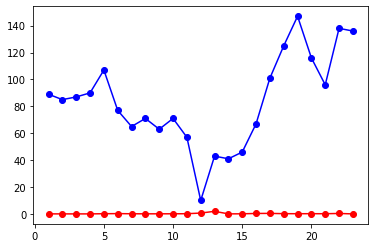

In [76]:
data_by_hour = words_time.select("word", "number", "month", "hour")
data_by_hour.show(5)

#Apply poisson method with hourly buckets
eta = poisson_method(data_by_hour, 'word', 0.95, 1)

### Question 5

In [16]:
hashtags = exp_words_f.filter( exp_words_f.word.startswith('#'))\
                      .withColumnRenamed('word', 'hashtag')

In [17]:
most_freq_hash = hashtags.groupBy('hashtag') \
    .count() \
    .sort('count', ascending=False) 
most_freq_hash.show(30)

+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|         #curecancer| 3987|
|       #iowacaucuses| 3184|
|#deshkiawaazshehnaaz| 2867|
|    #mainbhiasimkigf| 2772|
|      #meraadarshsid| 2681|
|       #iheartawards| 1713|
|                #bts| 1654|
|           #asimriaz| 1494|
|        #thebachelor| 1353|
|                 #bb| 1251|
|         #iowacaucus| 1249|
|     #sidharthshukla| 1235|
|           #treasure| 1232|
|        #coronavirus| 1155|
|           #biggboss| 1155|
|           #iacaucus| 1134|
|         #loveisland|  996|
|          #superbowl|  962|
|     #worldcancerday|  863|
|               #sotu|  842|
|     #rightchoicesid|  839|
|              #yikes|  758|
|     #happyjisungday|  706|
|         #nowplaying|  646|
|            #btsarmy|  646|
|                #nct|  640|
|             #superm|  573|
|               #iowa|  572|
|                #raw|  565|
|       #rashamidesai|  564|
+--------------------+-----+
only showing t

###### Converting Hashtag Data Frame to array:

In [18]:
mfht = most_freq_hash.filter('count >= 500').select('hashtag').rdd.map(lambda x: x[0]).collect()

###### Getting words related to Hashtag example:

In [21]:
event_words = exp_words_f.filter( f.col('text').contains('#iowacaucuses'))

event_words.groupBy('word') \
           .count() \
           .sort('count', ascending=False)\
           .rdd\
           .map(lambda x: x[0])\
           .collect()[:12]

['#iowacaucuses',
 'iowa',
 'bernie',
 'caucus',
 'vote',
 'won',
 'tonight',
 '#iowacaucus',
 'biden',
 'app',
 '@donaldjtrumpjr',
 'dnc']

#### Ex5 using pySpark:

In [19]:
## Ex.5: Get the most frequent words for each event:
ht_f = hashtags.select('filtered', 'hashtag')\
               .filter(f.col('hashtag').isin(mfht))\
               .withColumn('word', f.explode('filtered'))\
               .filter(~col('word').startswith('#'))\
               .select('hashtag', 'word')\
               .groupBy('hashtag', 'word')\
               .count()\
               .sort(['hashtag', 'count'], ascending=False)\
               .filter('count >= 100')

ht_f.show(10)
    

+---------------+-----------+-----+
|        hashtag|       word|count|
+---------------+-----------+-----+
|         #yikes|@nickiminaj|  451|
|         #yikes|      likes|  344|
|         #yikes|        amp|  336|
|         #yikes|       play|  325|
|         #yikes|        tag|  313|
|         #yikes|       life|  311|
|         #yikes|    yzdifvf|  310|
|         #yikes|       rosa|  130|
|         #yikes|      nicki|  111|
|#worldcancerday|     cancer|  347|
+---------------+-----------+-----+
only showing top 10 rows



#### Showing the top 10 most frequent words by events:

In [97]:
for ht in mfht:
    ht_f.filter(col('hashtag').isin(ht)).show(10)

+-----------+-----------+-----+
|    hashtag|       word|count|
+-----------+-----------+-----+
|#curecancer|trueworship| 3951|
|#curecancer|     cancer| 2441|
|#curecancer|       true| 1240|
|#curecancer|     rampal| 1073|
|#curecancer|    worship| 1042|
|#curecancer|      saint| 1040|
|#curecancer|       cure|  916|
|#curecancer|        god|  884|
|#curecancer|    maharaj|  859|
|#curecancer|   diseases|  846|
+-----------+-----------+-----+
only showing top 10 rows

+-------------+---------------+-----+
|      hashtag|           word|count|
+-------------+---------------+-----+
|#iowacaucuses|           iowa|  499|
|#iowacaucuses|         bernie|  346|
|#iowacaucuses|         caucus|  237|
|#iowacaucuses|           vote|  193|
|#iowacaucuses|            won|  173|
|#iowacaucuses|        tonight|  155|
|#iowacaucuses|          biden|  153|
|#iowacaucuses|            app|  151|
|#iowacaucuses|@donaldjtrumpjr|  150|
|#iowacaucuses|            dnc|  147|
+-------------+---------------+-

KeyboardInterrupt: 

### Question 6-7 with SparkRDD:

In [20]:
## Because we want to reduce and aggregate with respect to each event(hashtag), we choose hashtag to be our key:
# ht_rdd has (key=hashtag, value=(min(timestamp_ms), max(timestamp_ms), place.bounding_box.coordinates, number_of_places))
ht_rdd = hashtags.select('timestamp_ms', 'place.bounding_box.coordinates', 'hashtag')\
                 .filter(f.col('hashtag').isin(mfht))\
                 .rdd.map(lambda x: (x[2], (x[0], x[0], x[1], 0 if x[1] is None else 1)))


##### Aggregate function for finding minimum, maximum timeframe and the mean coordinates of each Event    

In [21]:
def aggregate_ts_place(x, y):
    # for calculating minimum timeframe
    ts1 = int(x[0])
    ts2 = int(y[0])
    # for calculating minimum timeframe    
    ts3 = int(x[1])
    ts4 = int(y[1])
    
    # for summing the coordinates
    place1 = x[2]
    place2 = y[2]
    
    # number of places of Event, needed for calculating the mean of the coordinates
    increment = 0
    
    # Considering that most of the Tweets don't have the coordinates
    # Aggregate function will select:
    # - None, in case both of tweets do not have
    if(place1 is None):
        if(place2 is None):
            place = None
    # - Coordinates of one, if only one of the has  
        else:
            place = place2
            increment = y[3]
        
    elif(place2 is None):
        place = place1
        increment = x[3]
    # - Sum of the coordinates if both of them have
    else:
        place = np.array(place1) + np.array(place2)
        place = place.squeeze()
        increment = x[3] + y[3]
    # Finally returns, min/max timeframe, coordinates of the place, and number of places for each Event        
    return (min(ts3, ts4), max(ts1, ts2), place, increment)

##### We now need to compute the means of all places:

In [57]:
# Calling the Aggregation function
aggreg_ht = ht_rdd.reduceByKey(lambda x, y: aggregate_ts_place(x, y))
aggreg_htn = aggreg_ht.map(lambda x: (x[0], x[1][0], x[1][1], np.array(x[1][2])/x[1][3] if x[1][3] != 0 else x[1][3], x[1][3]))
ts_loc_l = aggreg_htn.collect()

### Function that converts geolocalisation to place name:

In [71]:
def loc(coords):

    geolocator = Nominatim(user_agent="geoapiExercises")  
    if coords.shape != (2,):
        coords = coords.mean(axis = 0)
    
    Longitude = str(coords[0])
    Latitude = str(coords[1])
    
    location = geolocator.reverse(Latitude+","+Longitude)
    
    if(location == None):
        print("\tNo location specified")
        return
 
    address = location.raw['address']

    # traverse the data
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    code = address.get('country_code')
    zipcode = address.get('postcode')
    print('\tCity : ', city)
    print('\tState : ', state)
    print('\tCountry : ', country)
    print('\tZip Code : ', zipcode)

##### Printing the results 

In [72]:
for event in ts_loc_l:
    print("EVENT: " + event[0]+'\n')
    start = str(pd.to_datetime(event[1], unit='ms').to_pydatetime())
    end = str( pd.to_datetime(event[2], unit='ms').to_pydatetime())
    print("\tTimeframe : from - " + start[:-7] + " to - " + end[:-7]+'\n')
    
    if(np.sum(event[4]) == 0 ):
        print("\tNo location specified")
    else: 
        loc(event[3].squeeze())
    print("\n-----------------------------------------------------------------------\n")
        


EVENT: #treasure

	Timeframe : from - 2020-02-04 22:21:02 to - 2020-02-04 22:47:25

	No location specified

-----------------------------------------------------------------------

EVENT: #arsd

	Timeframe : from - 2020-02-04 21:54:36 to - 2020-02-04 22:54:08

	No location specified

-----------------------------------------------------------------------

EVENT: #iowa

	Timeframe : from - 2020-02-04 22:33:04 to - 2020-02-04 22:57:14

	City :  
	State :  Oklahoma
	Country :  United States
	Zip Code :  None

-----------------------------------------------------------------------

EVENT: #biggboss

	Timeframe : from - 2020-02-04 22:31:17 to - 2020-02-04 22:51:09

	City :  
	State :  Telangana
	Country :  India
	Zip Code :  500089

-----------------------------------------------------------------------

EVENT: #thebachelor

	Timeframe : from - 2020-02-04 22:18:15 to - 2020-02-04 22:35:01

	City :  
	State :  Kentucky
	Country :  United States
	Zip Code :  42633

---------------------------

### Exercise 6 and Exercice 7: with for loop method

In [77]:
for ht in mfht:
    event_words = exp_words_f.filter( f.col('text').contains(ht))
    event_texts = clean_texts.filter( f.col('text').contains(ht))

    ## Ex.5: Get the most frequent words for each event:
    most_freq_w = event_words.filter(~col('word').startswith('#'))\
                             .groupBy('word') \
                             .count() \
                             .sort('count', ascending=False)\
                             .rdd\
                             .map(lambda x: x[0])\
                             .collect()[:8]    
    
    # Ex.6 : Finding timeframe of the Event
    end   = event_texts.select(f.max(f.col('timestamp_ms'))).rdd.map(list).collect()[0][0]
    start = event_texts.select(f.min(f.col('timestamp_ms'))).rdd.map(list).collect()[0][0]
    
    # Ex.7 : Finding location of the Event
    coords = event_texts.na.drop(subset=["place"]) \
                        .select("place.bounding_box.coordinates") \
                        .rdd.map(list).collect()
    
    ## Gets the most common location from the tweets !
    location_name = event_texts.na.drop(subset=["place"]) \
                               .groupBy('place.name', 'place.country') \
                               .count()\
                               .sort('count', ascending=False)\
                               .rdd\
                               .map(lambda x : x[0] + ', ' + x[1])\
                               .collect()
    
    ####### Printing the results
    
    print("EVENT: " + ht+'\n')
    
    end = str( pd.to_datetime(end, unit='ms').to_pydatetime())
    start = str(pd.to_datetime(start, unit='ms').to_pydatetime())
    print("\tTimeframe : from - " + start[:-7] + " to - " + end[:-7]+'\n')
    
    # Printing the location found by the first method: The Most Common Location
    if(location_name != []):
        location_name = location_name[0]
    else:
        location_name = 'No Location specified'

    print("\tMost frequent Location is : " + location_name)
    
    # Printing the location found by the second method: The Mean Of Coordinates
    if(coords != []):
        coords_mean = np.array(coords).squeeze().mean(axis = 0)
        loc(coords_mean)
    else: 
        print("\tNo location specified")
    
    # Printing most frequent words
    if(most_freq_w == []):
        most_freq_w = 'no words found...'
    

    print("\n\tMost frequent words associated to the event: \n\t" + str(most_freq_w))
    print("\n------------------------------------------------------------------------------------------------\n")

Event: #curecancer

	Timeframe : from - 2020-02-04 03:16:13 to - 2020-02-04 22:42:39

	Most frequent Location is : karnal, India
	City :  
	State :  Madhya Pradesh
	Country :  India
	Zip Code :  476332

	Most frequent words associated to the event: 
	['trueworship', 'cancer', 'true', 'rampal', 'saint', 'worship', 'cure', 'god']

------------------------------------------------------------------------------------------------

Event: #iowacaucuses

	Timeframe : from - 2020-02-03 23:00:11 to - 2020-02-04 22:58:28

	Most frequent Location is : Manhattan, United States
	City :  
	State :  West Virginia
	Country :  United States
	Zip Code :  None

	Most frequent words associated to the event: 
	['iowa', 'bernie', 'caucus', 'vote', 'won', 'app', '@donaldjtrumpjr', 'party']

------------------------------------------------------------------------------------------------

Event: #deshkiawaazshehnaaz

	Timeframe : from - 2020-02-04 01:58:49 to - 2020-02-04 22:59:12

	Most frequent Location is : 

##### Benchmarking of the different methods for finding minimum / maximum timestamp

In [25]:
# Method 1: Use describe()
t1 = time.time()
float(event_words.describe("timestamp_ms").filter("summary = 'max'").select("timestamp_ms").collect()[0].asDict()['timestamp_ms'])

t2 = time.time()
print("Method 1")
print("time spent computing: {:.4g}".format(t2-t1))

# Method 2: Use SQL
t1 = time.time()

event_words.registerTempTable("df_table")
spark.sql("SELECT MAX(timestamp_ms) as maxval FROM df_table").collect()[0].asDict()['maxval']

t2 = time.time()
print("Method 2")
print("time spent computing: {:.4g}".format(t2-t1))

# Method 3: Convert to RDD
t1 = time.time()

event_words.select("timestamp_ms").rdd.max()[0]

t2 = time.time()
print("Method 3")
print("time spent computing: {:.4g}".format(t2-t1))


# Method 4: select
t1 = time.time()

event_words.select(f.max(f.col('timestamp_ms')))

t2 = time.time()
print("Method 4")
print("time spent computing: {:.4g}".format(t2-t1))

Method 1
time spent computing: 6.778
Method 2
time spent computing: 6.634
Method 3
time spent computing: 6.558
Method 4
time spent computing: 0.009586


## Question 8:

Use NLP package from [nltk](https://www.nltk.org/api/nltk.sentiment.html).

In [54]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
#sid.polarity_scores(sentence)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /users/eleves-a/2018/jean-charles.layoun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Sentiment analysis most frequent hashtags:

Following the **map reduce** paradigm to compute the sentiment associated with each event.

###### Map by hashtags:

In [55]:
sentiments_rdd = hashtags.select('filtered', 'hashtag')\
                         .filter(f.col('hashtag').isin(mfht))\
                         .rdd.map(lambda x: (x[1], sid.polarity_scores(' '.join(x[0]))))

## Because we want to reduce and aggregate with respect to each event(hashtag), we choose hashtag to be our key:
# sentiments_rdd has (key=hashtag, value=sentiment)
t1 = time.time()
sentiments_rdd.collect()
t2 = time.time()
time1 = t2-t1

In [56]:
sentiments_rdd.take(10)

[('#superbowl', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#btsarmy', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#coronavirus', {'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.5574}),
 ('#coronavirus', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#thebachelor', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#iowacaucuses', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#bts', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#nowplaying', {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.2732}),
 ('#bts', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#giveaway', {'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.5859})]

###### Reduce on Hashtags:

In [57]:
def aggregate_sentiments(x, y):
    dict1 = x
    dict2 = y    
    
    for key in dict1.keys():
        dict1[key] += dict2[key]
        
    return dict1
    

aggreg = sentiments_rdd.reduceByKey(lambda x, y: aggregate_sentiments(x, y))

In [58]:
t1 = time.time()
event_sentiments_l = aggreg.collect()
t2 = time.time()
time2 = t2-t1

event_sentiments_l[:5]

[('#treasure',
  {'neg': 4.951999999999999,
   'neu': 1030.175000000003,
   'pos': 196.87100000000038,
   'compound': 349.67990000000117}),
 ('#arsd',
  {'neg': 35.58,
   'neu': 451.28099999999995,
   'pos': 50.13499999999999,
   'compound': 35.2231}),
 ('#iowa',
  {'neg': 73.184,
   'neu': 521.3799999999999,
   'pos': 101.45099999999998,
   'compound': 55.191799999999986}),
 ('#biggboss',
  {'neg': 61.392999999999994,
   'neu': 872.8369999999999,
   'pos': 221.77900000000002,
   'compound': 289.0983999999999}),
 ('#thebachelor',
  {'neg': 133.68300000000002,
   'neu': 1076.398,
   'pos': 147.925,
   'compound': 23.1815})]

In [59]:
def normalize_sentiment(x):
    dict1    = x
    sum_prob = dict1['neg'] + dict1['neu'] + dict1['pos']
    
    for key in dict1.keys():
        dict1[key] /= sum_prob
    return dict1


aggreg_normalized = aggreg.map(lambda x: (x[0], normalize_sentiment(x[1])))

In [60]:
t1 = time.time()
event_sentiments_ln = aggreg_normalized.collect()
t2 = time.time()
time3 = t2-t1

In [61]:
event_sentiments_ln[:8]

[('#treasure',
  {'neg': 0.0040194870446218145,
   'neu': 0.8361823639324092,
   'pos': 0.15979814902296907,
   'compound': 0.2838315484278386}),
 ('#arsd',
  {'neg': 0.06625747677822555,
   'neu': 0.8403805614939405,
   'pos': 0.0933619617278341,
   'compound': 0.06559285357805274}),
 ('#iowa',
  {'neg': 0.1051471591847877,
   'neu': 0.7490930511555067,
   'pos': 0.1457597896597056,
   'compound': 0.07929685423446334}),
 ('#biggboss',
  {'neg': 0.05310771801949638,
   'neu': 0.7550434295926761,
   'pos': 0.19184885238782745,
   'compound': 0.2500831740929352}),
 ('#thebachelor',
  {'neg': 0.09844065490137749,
   'neu': 0.792631254942909,
   'pos': 0.10892809015571361,
   'compound': 0.0170702485850578}),
 ('#asimriaz',
  {'neg': 0.06977859288060737,
   'neu': 0.7629025185663331,
   'pos': 0.16731888855305946,
   'compound': 0.15989261982882397}),
 ('#curecancer',
  {'neg': 0.2291470615972054,
   'neu': 0.5569524341721126,
   'pos': 0.213900504230682,
   'compound': -0.0994352485939529

In [62]:
print("time spent computing the sentiments, aggregating and normalizing: {:.4g}s".format(time1 + time2 + time3))

time spent computing the sentiments, aggregating and normalizing: 39.36s


#### Computing average sentiment on all tweets:

In [63]:
sentences_rdd  = words_f.select('filtered').rdd.map(lambda x: ' '.join(x[0]))

In [70]:
num_sentences = len(sentences)

In [64]:
t1 = time.time()
sentences = sentences_rdd.collect()
t2 = time.time()
time4 = t2-t1

In [71]:
t1 = time.time()
overall_sent = {'neg': 0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
for sentence in sentences:
    sentiment = sid.polarity_scores(sentence)    
    for key in overall_sent.keys():
        overall_sent[key] += sentiment[key]
        
    
for key in overall_sent.keys():
        overall_sent[key] /= num_sentences
overall_sent
t2 = time.time()
time5 = t2-t1

In [72]:
print("time spent computing the sentiments not using an rdd: {:.4g}s".format(time4 + time5))

time spent computing the sentiments not using an rdd: 82.31s


##### Conclusion:
We can clearly see that using an rdd and utilizing the map reduce scheme gives us faster performance! Also, the naive algorithm above doesn't even group by hashtags...

### Question 9:
We cluster tweets with the k-mean method using the **RDD** framework.

##### Vectorizing words with [TF-IDF](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html#tf-idf):

In [91]:
from pyspark.mllib.feature import HashingTF, IDF

hashingTF = HashingTF()
tf = hashingTF.transform(words_f.select("filtered").rdd.map(lambda x: x[0]))

tf.cache()
idf = IDF().fit(tf)
tfidf = idf.transform(tf)



#### Computing centers:

In [ ]:
from pyspark.mllib.clustering import KMeans, KMeansModel

print(tfidf.take(5))

# Build the model (cluster the data)
clusters = KMeans.train(tfidf, 2, maxIterations=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return np.sqrt(sum([x**2 for x in (point - center)]))

WSSSE = tfidf.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
#clusters.save(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")
#sameModel = KMeansModel.load(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")

[SparseVector(1048576, {126401: 13.146, 1033662: 7.7101}), SparseVector(1048576, {19714: 8.1972, 59160: 11.4412, 364656: 12.0474, 502212: 11.2742, 597083: 10.1255, 678402: 11.4412, 753745: 10.8434, 774182: 6.5502, 872460: 5.72, 950256: 8.6858, 1037592: 11.7597}), SparseVector(1048576, {160946: 11.2001, 200945: 4.7851, 504736: 9.6196, 835156: 7.6205}), SparseVector(1048576, {243115: 7.0547, 423907: 3.4228, 808660: 7.7753, 905187: 6.875, 905836: 9.4953, 1003152: 9.0516, 1021457: 8.2632}), SparseVector(1048576, {184188: 5.4007, 208645: 6.1169, 234454: 10.1756, 252073: 7.787, 564680: 6.9722, 655950: 5.6096, 662358: 6.0426, 1038027: 4.1151})]


### Question 10:
Our First idea was to try to predict the number of retweets a tweet can get. Unfortunately, the data provided in `NoFilterEnglish2020-02-0` **1 to 7** does not contain any retweeted data...

In [36]:
data.filter('retweeted or retweet_count >0').select('retweeted', 'created_at', 'possibly_sensitive').show(4)

+----------+------------------+
|created_at|possibly_sensitive|
+----------+------------------+
+----------+------------------+



But, all hope is not lost ! We can predict if a tweet is possibly sensitive or not !

In [42]:
data.filter('possibly_sensitive').select('created_at', 'possibly_sensitive').show(4)

+--------------------+------------------+
|          created_at|possibly_sensitive|
+--------------------+------------------+
|Mon Feb 03 22:59:...|              true|
|Mon Feb 03 22:59:...|              true|
|Mon Feb 03 22:59:...|              true|
|Mon Feb 03 23:00:...|              true|
+--------------------+------------------+
only showing top 4 rows



##### Thus we are going to do the next best thing and try to predict if a tweet is `possibly_sensitive`:

In [38]:
features = [ 'favorite_count', 'favorited', 'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'quote_count', 'timestamp_ms', 'retweeted', 'possibly_sensitive']#'retweet_count'

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Select Data:
features_and_labels = data.select('favorite_count', 'favorited', 'id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'quote_count', col('timestamp_ms').cast('float').alias('timestamp_ms'), col('retweeted').cast('int').alias('retweeted'), col('possibly_sensitive').cast('int'))\
                           .na.drop(subset = features)

In [40]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler().setInputCols(features[:-1]).setOutputCol('features')
features_and_labels = assembler.transform(features_and_labels)

In [41]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="possibly_sensitive", outputCol="indexedLabel").fit(features_and_labels)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol='features', outputCol="indexedFeatures", maxCategories=4).fit(features_and_labels)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = features_and_labels.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(8,[2,3,4,6],[1.2...|
|       0.0|         0.0|(8,[2,3,4,6],[1.2...|
|       0.0|         0.0|(8,[2,3,4,6],[1.2...|
|       0.0|         0.0|(8,[2,3,4,6],[1.2...|
|       0.0|         0.0|(8,[2,3,4,6],[1.2...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.0370515
GBTClassificationModel: uid = GBTClassifier_ebd581c56278, numTrees=10, numClasses=2, numFeatures=8
